# Data Assignment 3 -  Poverty detection using Night lights

We will be looking at 4 different methodologies here
- Find a Polynomical regression model to detect poverty by disregarding the years and countries
- Fit a Lasso model on Night lights to reduce colinearity
- Run Polynomical regression on each variable and Night lights (DMSP)
- Run a Time series model to predict other features using Night lights. 


In [1]:
import csv
import pandas as pd
import scipy 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PolynomialFeatures

In [2]:
dat = pd.read_csv("total.csv")
x_data = dat['Log_DMSP']
y_data = dat.drop(["REGION",  "SUBREGION", "Country", "Date","Log_DMSP", "Unnamed: 0"], axis= 1)
cols = y_data.columns
len(cols)

26

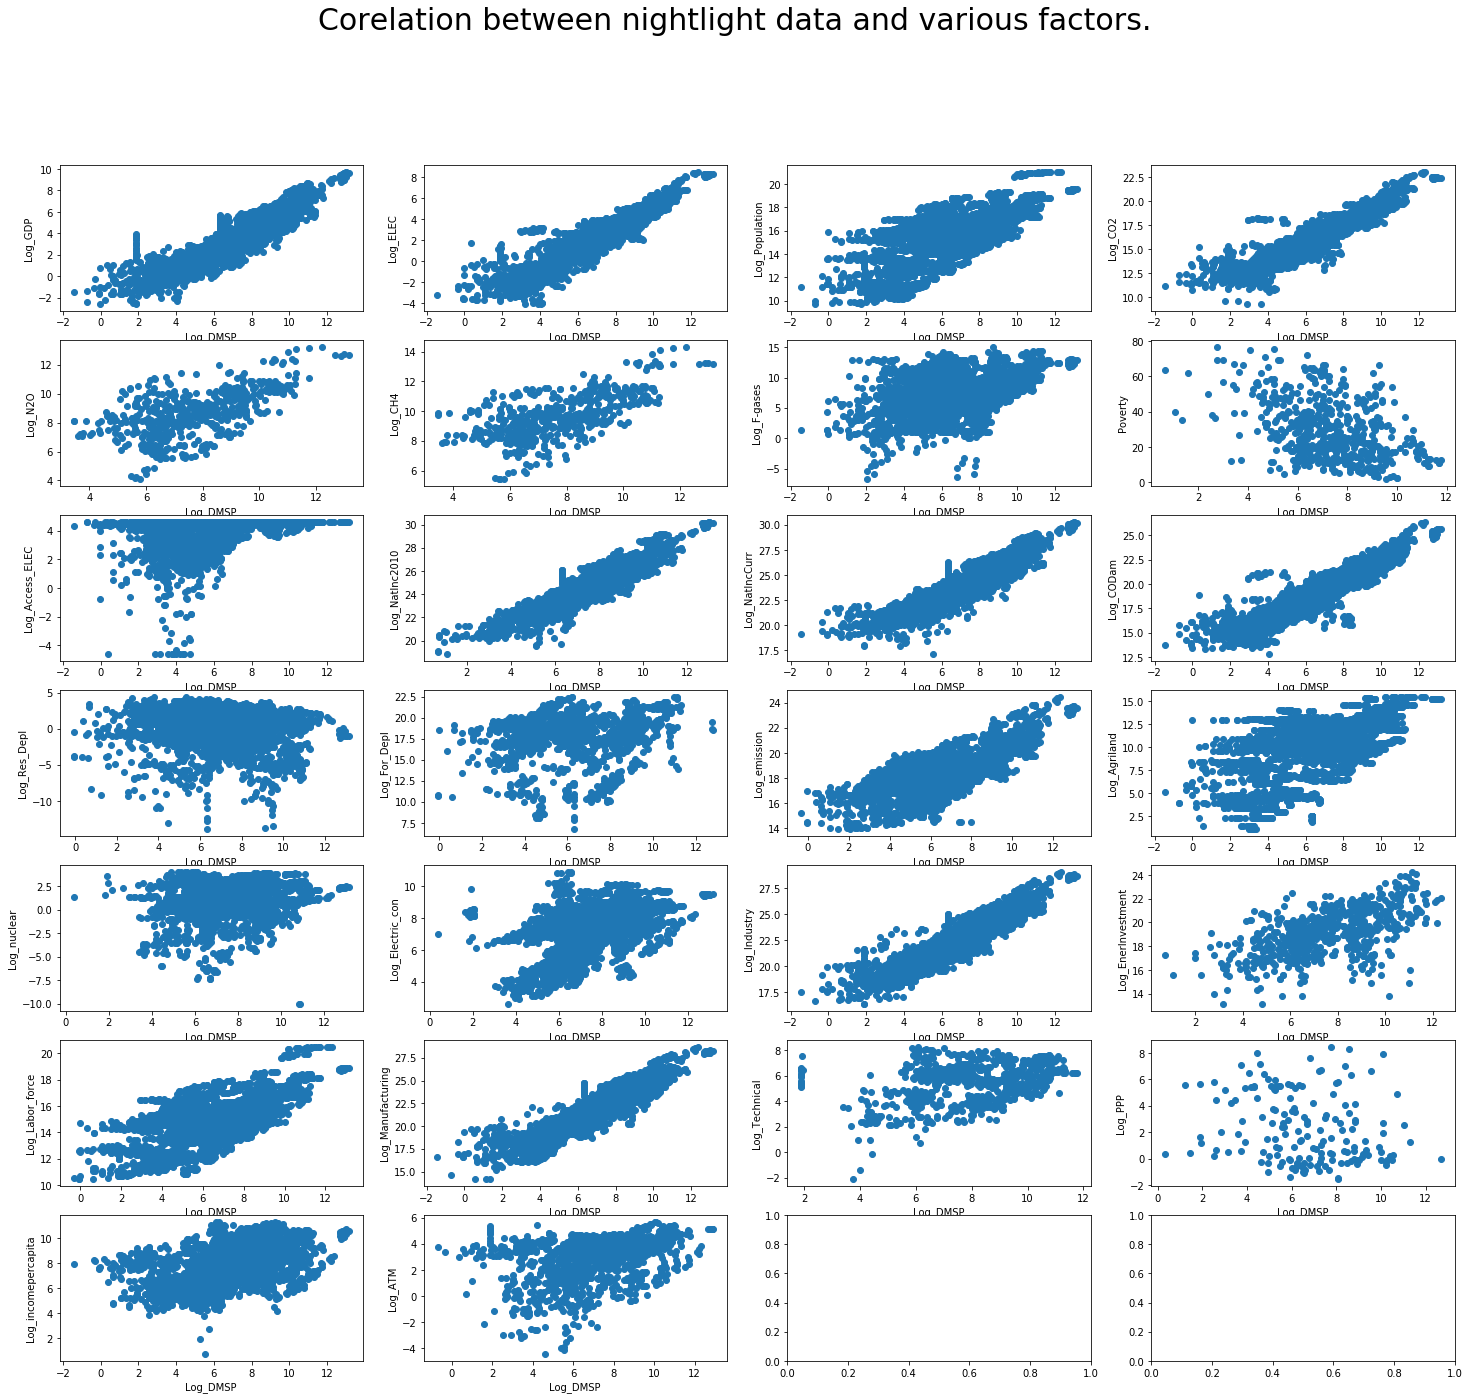

In [3]:
fig, ax = plt.subplots(7,4,figsize=(25, 22))
Logs = ['Access_ELEC',
       'NatInc2010', 'NatIncCurr', 'CODam', 'Res_Depl', 'For_Depl', 'emission',
       'Agriland', 'nuclear', 'Electric_con', 'Industry', 'EnerInvestment',
       'Labor_force', 'Manufacturing', 'Technical', 'PPP', 'incomepercapita',
       'ATM']

for j in range(0, 7):
    for i in range(0, 4):
        if j*4 + i < len(cols):
            k = j*4 + i
            if k ==len(cols):
                break
            if cols[k] in Logs:
                ax[j, i].scatter(x_data, np.log(y_data[cols[k]].astype(float)), label=cols[k])
                ax[j, i].set_ylabel("Log_" + cols[k])
            else:
                ax[j, i].scatter(x_data, y_data[cols[k]].astype(float), label=cols[k])
                ax[j, i].set_ylabel(cols[k])
            ax[j, i].set_xlabel("Log_DMSP")
  

fig.suptitle('Corelation between nightlight data and various factors.', fontsize=30)
fig.savefig('irispairplot.png')
plt.show()



Now, Let us only take the most correlated columns, which are
- Log_GDP
- Log_ELEC
- Log_CO2
- Log_NatIncCurr (Net National income)
- Log_Carbon_dioxide_damage (USD)
- Log_emmission (particulate emission damage)
- Log_Industry - Industry (including construction), value added
- Log_Manufacturing - Manufacturing, value added
- Log_EnerInvestment - Investment in energy with private participation
- Log_Labor Force

We will also Take the Poverty variable.

In [4]:
cols
Logs = ["Poverty", 'NatIncCurr', 'CODam','emission','Industry','Labor_force', 'Manufacturing']

## 1. Polynomical regression model to detect poverty by disregarding the years and countries

As we had a look at the scatter plot of Log of Poverty to Log Log_DMSP

In [5]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import matthews_corrcoef

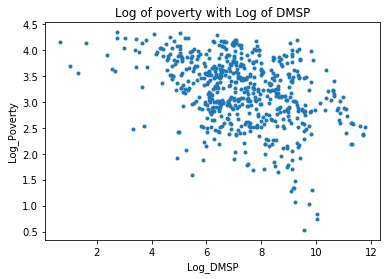

In [6]:
pov_dat = dat[["Log_DMSP", "Poverty"]].dropna()
pov_dat["Poverty"] = np.log(pov_dat["Poverty"])
fig, ax = plt.subplots(1,1)
ax.plot(pov_dat["Log_DMSP"], pov_dat["Poverty"], '.')
ax.set_title("Log of poverty with Log of DMSP")
ax.set_ylabel("Log_Poverty")
ax.set_xlabel("Log_DMSP")
plt.show()


In [7]:
X_train,X_test,y_train,y_test = train_test_split(pov_dat["Log_DMSP"], pov_dat["Poverty"], random_state = 10)
std= StandardScaler()
X_train = std.fit_transform(X_train.values.reshape(-1,1))
X_test = std.transform(X_test.values.reshape(-1,1))
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

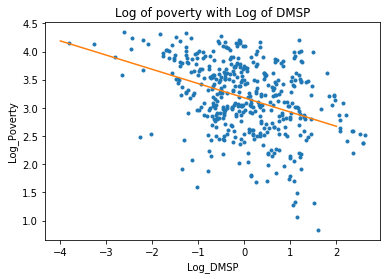

In [8]:
lr= LinearRegression().fit(X_train, y_train)
line = np.linspace(-4,2,100).reshape(-1,1)
plt.plot(X_train, y_train, '.')
plt.title("Log of poverty with Log of DMSP")
plt.ylabel("Log_Poverty")
plt.xlabel("Log_DMSP")
plt.plot(line,lr.predict(line)) 


0.16211583522088235

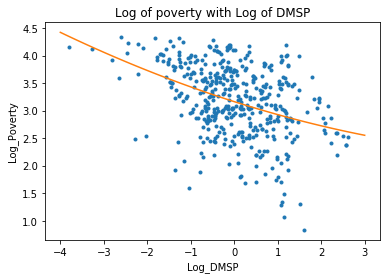

In [9]:
poly_lr= make_pipeline(PolynomialFeatures(include_bias=False),LinearRegression())
poly_lr.fit(X_train,y_train)
line = np.linspace(-4,3,100).reshape(-1,1)
plt.plot(X_train, y_train, '.')
plt.title("Log of poverty with Log of DMSP")
plt.ylabel("Log_Poverty")
plt.xlabel("Log_DMSP")
plt.plot(line,poly_lr.predict(line))
poly_lr.score(X_test,y_test)

In [10]:
print("The Corelation between linear features of Night lights and Poverty is " + str(round(lr.score(X_test,y_test), 2)))
print("The Corelation between Polynomial features of Night lights and Poverty is " + str(round(poly_lr.score(X_test,y_test), 2)))

The Corelation between linear features of Night lights and Poverty is 0.17
The Corelation between Polynomial features of Night lights and Poverty is 0.16


It looks like a regression model to directly corelate fails drastically. Hence we will try to correlate and predict other indicators of poverty using night lights

## 2. Lasso Model to statistically fit night lights data.



In [11]:
dat.head()
df = dat


In [12]:
df["Date_Time"] = pd.to_datetime(df.Date, format = '%Y')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time
data = data.drop(["REGION",  "SUBREGION", "Country", "Date"], axis = 1)



In [13]:
logs = ["Poverty", 'NatIncCurr', 'CODam','emission','EnerInvestment','Industry','Labor_force', 'Manufacturing']
core_data = data[['Log_DMSP','Log_GDP', 'Log_ELEC','Log_CO2','NatIncCurr', 'CODam','emission','EnerInvestment',
                  'Industry','Labor_force','Manufacturing']]
col_t = core_data.columns
for col in col_t:
    if col in logs:
        core_data[col] = np.log(core_data[col])
        core_data.rename(columns={col:"Log_" + col }, inplace=True)
main_data = core_data.dropna()      
train = main_data[:int(0.8*(len(main_data)))]
test = main_data[int(0.8*(len(main_data))):]


In [14]:
X_train = train.drop("Log_DMSP", axis  = 1)
X_test = test.drop("Log_DMSP", axis  = 1)
y_train = train["Log_DMSP"].values
y_test = test["Log_DMSP"].values

std= StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [15]:
lr= Lasso(alpha = 0.1).fit(X_train, y_train)
print("The R2 value for the lasso model is " + str(round(lr.score(X_test, y_test),2))) 


The R2 value for the lasso model is 0.95


In [16]:
for i in range(0,len(train.columns)-1):
    if (lr.coef_[i] != 0):
        print("The coefficient of " + train.columns[i+1] + " is " + str(round(lr.coef_[i], 4) ))

The coefficient of Log_GDP is 0.4974
The coefficient of Log_ELEC is 0.5942
The coefficient of Log_CO2 is 0.4867
The coefficient of Log_Industry is 0.283


The Lasso pushes the other constants to zero   


## 3 Linear models for Individual vaiables



In [17]:
lim_cols = core_data.columns[1:]
indep = "Log_DMSP"
for col in lim_cols:
    indep_dat = core_data[[indep, col]]
    indep_dat = indep_dat.dropna()
    itrain = indep_dat[:int(0.8*(len(indep_dat)))]
    itest = indep_dat[int(0.8*(len(indep_dat))):]
    X_train = itrain["Log_DMSP"].values
    X_test = itest["Log_DMSP"].values
    y_train = itrain[col].values
    y_test = itest[col].values
    poly = PolynomialFeatures(degree = 2)
    X_train_poly = poly.fit_transform(X_train.reshape(-1, 1))
    X_test_poly = poly.transform(X_test.reshape(-1, 1))
    plr= LinearRegression().fit(X_train_poly, y_train)
    print("The R2 value for the Polynomial Linear model of " + col + " is " + str(round(plr.score(X_test_poly, y_test),2)))


The R2 value for the Polynomial Linear model of Log_GDP is 0.84
The R2 value for the Polynomial Linear model of Log_ELEC is 0.88
The R2 value for the Polynomial Linear model of Log_CO2 is 0.88
The R2 value for the Polynomial Linear model of Log_NatIncCurr is 0.85
The R2 value for the Polynomial Linear model of Log_CODam is 0.87
The R2 value for the Polynomial Linear model of Log_emission is 0.6
The R2 value for the Polynomial Linear model of Log_EnerInvestment is 0.12
The R2 value for the Polynomial Linear model of Log_Industry is 0.82
The R2 value for the Polynomial Linear model of Log_Labor_force is 0.49
The R2 value for the Polynomial Linear model of Log_Manufacturing is 0.84


## 4. Time series model to relate other features with Night lights data.

We will be trying 2 models. 

- VAR
- ARMAX

Time series models will be built for different countries differently. So we will be picking up a developing country to test how the models work. We will test the model on India

### 2.1 VAR


In [18]:
ind_data = dat[dat["Country"]=="IND"]
df = ind_data
df["Date_Time"] = pd.to_datetime(df.Date, format = '%Y')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time
data = data.dropna(axis=1).drop(["REGION",  "SUBREGION", "Country", "Date"], axis = 1)


In [19]:
logs = ["Poverty", 'NatIncCurr', 'CODam','emission','EnerInvestment','Industry','Labor_force', 'Manufacturing']
main_data = data[['Log_DMSP','Log_GDP', 'Log_ELEC','Log_CO2','NatIncCurr', 'CODam','emission','EnerInvestment',
                  'Industry','Labor_force','Manufacturing']]
col_t = main_data.columns
for col in col_t:
    if col in logs:
        main_data[col] = np.log(main_data[col])
        main_data.rename(columns={col:"Log_" + col }, inplace=True)

train = main_data[:int(0.8*(len(main_data)))]
valid = main_data[int(0.8*(len(main_data))):]


In [20]:
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(endog=train)
model_fit = model.fit()
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [21]:
cols_n = valid.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols_n])
for j in range(0,len(cols_n)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [22]:
pred

,Log_DMSP,Log_GDP,Log_ELEC,Log_CO2,Log_NatIncCurr,Log_CODam,Log_emission,Log_EnerInvestment,Log_Industry,Log_Labor_force,Log_Manufacturing
0,10.1956,6.99207,6.45414,21.3048,27.5513,24.2958,23.3399,20.4621,26.4072,19.9795,25.7184
1,10.4078,6.89125,6.41666,21.3728,27.4504,24.3638,23.2463,22.7859,26.2264,20.0041,25.4737
2,10.4415,6.70794,6.40395,21.3395,27.2588,24.3607,23.0869,19.3044,26.0093,20.0483,25.2445
3,10.4858,6.7459,6.42521,21.3012,27.3028,24.3547,23.0747,18.9156,26.0597,20.0979,25.3128
4,10.7165,6.96996,6.48019,21.3268,27.5206,24.4349,23.1832,20.1638,26.4151,20.1478,25.703


In [23]:
from sklearn.metrics import mean_squared_error
for i in cols_n:
    print('Average Rmse value for', i, 'is : ', round(np.sqrt(mean_squared_error(pred[i], valid[i]))/np.mean(valid[i]),5))


Average Rmse value for Log_DMSP is :  0.05036
Average Rmse value for Log_GDP is :  0.08453
Average Rmse value for Log_ELEC is :  0.03884
Average Rmse value for Log_CO2 is :  0.00461
Average Rmse value for Log_NatIncCurr is :  0.02243
Average Rmse value for Log_CODam is :  0.00979
Average Rmse value for Log_emission is :  0.02422
Average Rmse value for Log_EnerInvestment is :  0.14019
Average Rmse value for Log_Industry is :  0.02824
Average Rmse value for Log_Labor_force is :  0.00455
Average Rmse value for Log_Manufacturing is :  0.03324


### 2.2 ARMAX



In [24]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train["Log_GDP"],exog=train["Log_DMSP"], order=(5, 1))
model_fit = model.fit(disp=False)
pred = model_fit.predict("2009-01-01", "2013-01-01", exog=valid["Log_DMSP"])


C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [25]:
pred 


2009-01-01    7.162706
2010-01-01    7.239753
2011-01-01    7.282438
2012-01-01    7.388040
2013-01-01    7.504271
Freq: AS-JAN, dtype: float64

In [26]:
valid["Log_GDP"] 



Date_Time
2009-01-01    7.22
2010-01-01    7.44
2011-01-01    7.54
2012-01-01    7.53
2013-01-01    7.54
Name: Log_GDP, dtype: float64

In [29]:
valid["Log_GDP"] - pred


Date_Time
2009-01-01    0.753826
2010-01-01    0.895367
2011-01-01    0.951879
2012-01-01    0.883134
2013-01-01    0.840956
dtype: float64

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(pred, )

Multiple models


In [28]:
for col in cols_n:
    if col == "Log_DMSP":
        continue;
    model = ARMA(train[col],exog=train["Log_DMSP"], order=(2, 1))
    model_fit = model.fit(disp=False)
    pred = model_fit.predict("2009-01-01", "2013-01-01", exog=valid["Log_DMSP"])
    
    print('Normalized Rmse value for', col, 'is : ', round(np.sqrt(mean_squared_error(valid[col],pred))/np.mean(valid[i]),5)) 
    

C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Normalized Rmse value for Log_GDP is :  0.01324


C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ameya\AppData\Local\conda\conda\envs\coms007\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Normalized Rmse value for Log_ELEC is :  0.00338


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.